# 🐥 Project 03: 가구 이미지 모델 분류
---
## 주제: 가구 분류 (미세 조정 fine_tuning (유사도 높은 데이터세트 탐색))
---
### 목표 (Target)
- **almirah_dataset (옷장)**
- **chair_dataset (의자)**
- **fridge dataset (냉장고)**
- **table dataset (테이블)**
- **tv dataset (텔레비젼)**


### 목차
1. 데이터셋 불러오기.
2. 데이터 프레임으로 file 경로 및 target 분류.
3. fine_tuning을 통한 학습 시간의 효율적 확보.
4. 데이터 훈련.
5. 데이터 검증.
6. 결론.

## 1. 이미지 불러오기

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/p_furniture/'

IMAGE_SIZE = 128
BATCH_SIZE = 64

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
print(generator.class_indices)

Found 15000 images belonging to 5 classes.
{'almirah_dataset': 0, 'chair_dataset': 1, 'fridge dataset': 2, 'table dataset': 3, 'tv dataset': 4}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'almirah_dataset',
 1: 'chair_dataset',
 2: 'fridge dataset',
 3: 'table dataset',
 4: 'tv dataset'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [4]:
import pandas as pd

f_df = pd.DataFrame({'file_paths': generator.filepaths,'target_names': target_names, 'targets': generator.classes})
f_df

,file_paths,target_names,targets
0,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
1,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
2,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
3,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
4,./datasets/p_furniture/almirah_dataset/image_1...,almirah_dataset,0
...,...,...,...
14995,./datasets/p_furniture/tv dataset/image_995.jpeg,tv dataset,4
14996,./datasets/p_furniture/tv dataset/image_996.jpeg,tv dataset,4
14997,./datasets/p_furniture/tv dataset/image_997.jpeg,tv dataset,4
14998,./datasets/p_furniture/tv dataset/image_998.jpeg,tv dataset,4


In [5]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(f_df.file_paths, 
                 f_df.targets, 
                 stratify=f_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
3    2400
0    2400
2    2400
1    2400
4    2400
Name: count, dtype: int64
targets
2    600
4    600
0    600
3    600
1    600
Name: count, dtype: int64


In [6]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify = train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
2    1920
0    1920
1    1920
3    1920
4    1920
Name: count, dtype: int64
targets
3    480
0    480
1    480
4    480
2    480
Name: count, dtype: int64
targets
2    600
4    600
0    600
3    600
1    600
Name: count, dtype: int64


## 2. 데이터 프레임 분리

In [7]:
train_df = f_df.iloc[train_images.index].reset_index(drop=True)
validation_df = f_df.iloc[validation_images.index].reset_index(drop=True)
test_df = f_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(9600, 3)
(2400, 3)
(3000, 3)


## 3-1. 유사도를 확인하기 위해 사전 훈련 모델을 통한 이미지 데이터 확인
- VGG 모델을 사용했을 때 특정 이미지에 대하여 정확한 분류를 진행하였기 때문에 유사도가 높은 것으로 판단.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 1:
('n04239074', 'sliding_door', 0.9773481)
sliding_door 97.7348%


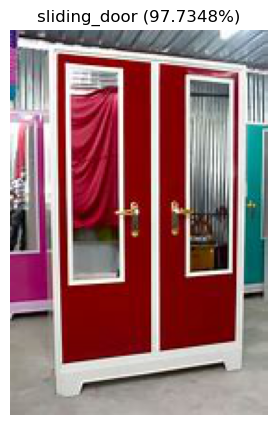



Image 2:
('n04590129', 'window_shade', 0.302527)
window_shade 30.2527%


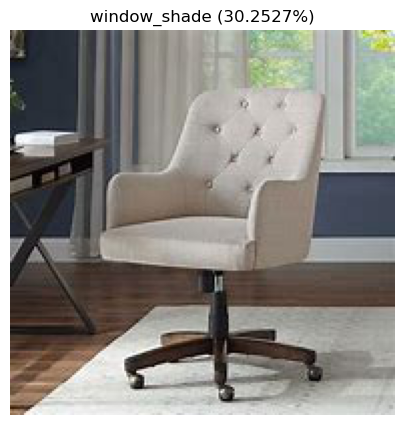



Image 3:
('n04550184', 'wardrobe', 0.6346494)
wardrobe 63.4649%


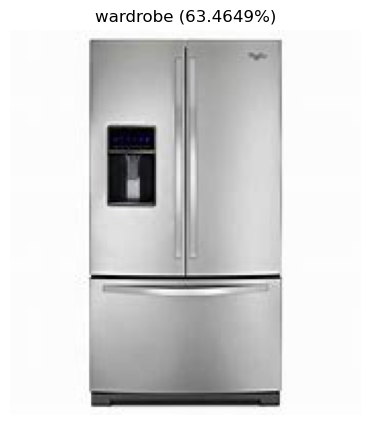



Image 4:
('n03201208', 'dining_table', 0.94068795)
dining_table 94.0688%


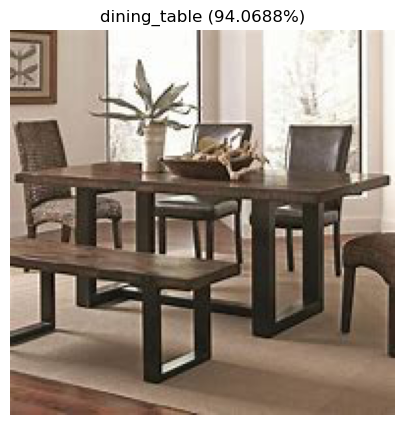



Image 5:
('n04404412', 'television', 0.80063295)
television 80.0633%


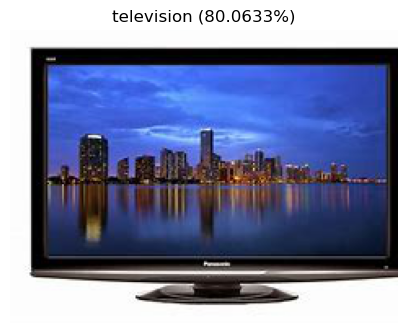

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions


# 모델을 로드합니다.
model = VGG16(weights='imagenet')

# 이미지를 로드하고 전처리하는 함수입니다.
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    image = load_img(img_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# 이미지 출력 함수 선언
def show_image_with_prediction(image, prediction):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    title = f'{prediction[1]} ({np.round(float(prediction[2]) * 100, 4)}%)'
    plt.title(title)
    plt.show()

# 이미지 파일 경로 리스트를 정의합니다.
image_paths = [
    './datasets/p_furniture/almirah_dataset/image_1.jpeg',
    './datasets/p_furniture/chair_dataset/image_1.jpeg',
    './datasets/p_furniture/fridge dataset/image_1.jpeg',
    './datasets/p_furniture/table dataset/image_1.jpeg',
    './datasets/p_furniture/tv dataset/image_1.jpeg'
]

# 이미지를 로드하고 배열로 변환합니다.
images = np.vstack([load_and_preprocess_image(img_path) for img_path in image_paths])

# 예측을 수행합니다.
predictions = model.predict(images)

# 예측 결과를 디코딩하고 출력합니다.
for i, img_path in enumerate(image_paths):
    # 원본 이미지를 로드하고 색상 변환
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    prediction = decode_predictions(np.expand_dims(predictions[i], axis=0))
    
    # 예측 결과 출력 및 이미지 표시
    print(f"Image {i + 1}:")
    print(prediction[0][0])
    print(prediction[0][0][1], f'{np.round(prediction[0][0][2] * 100, 4)}%')
    
    show_image_with_prediction(image, prediction[0][0])
    print("\n")


## 3-2. 일반화를 위한 데이터 증강 및 미세조정 사용
- 초기 훈련 시 속도를 확인 하기 위하여 전체 layer 에 대하여 unfreeze 이후 훈련 진행

In [10]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 64
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [13]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 부분 freeze 진행
    for layer in model.layers:
        layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset)
    
    return model, history

In [14]:
model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# freeze 확인하기
for i, layer in enumerate(model.layers[:-3]):
    # layer.trainable = False
    print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

print('\n######### classifier layers ######### ')
for layer in model.layers[-3:]:
    print(layer.name, 'trainable:', layer.trainable)

1 . input_layer_1 trainable: True
2 . block1_conv1 trainable: True
3 . block1_conv2 trainable: True
4 . block1_pool trainable: True
5 . block2_conv1 trainable: True
6 . block2_conv2 trainable: True
7 . block2_pool trainable: True
8 . block3_conv1 trainable: True
9 . block3_conv2 trainable: True
10 . block3_conv3 trainable: True
11 . block3_pool trainable: True
12 . block4_conv1 trainable: True
13 . block4_conv2 trainable: True
14 . block4_conv3 trainable: True
15 . block4_pool trainable: True
16 . block5_conv1 trainable: True
17 . block5_conv2 trainable: True
18 . block5_conv3 trainable: True
19 . block5_pool trainable: True

######### classifier layers ######### 
global_average_pooling2d trainable: True
dense trainable: True
output trainable: True


## 4-1-1. fine_tuning 을 통한 전체 conv에 대하여 훈련 진행
- VGG16 모델 사용

In [16]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 110s 732ms/step - acc: 0.6384 - loss: 4.2178 - val_acc: 0.9542 - val_loss: 0.1723
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 835ms/step - acc: 0.9291 - loss: 0.3208 - val_acc: 0.9908 - val_loss: 0.0271
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 847ms/step - acc: 0.9527 - loss: 0.1830 - val_acc: 1.0000 - val_loss: 0.0063
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 870ms/step - acc: 0.9711 - loss: 0.1143 - val_acc: 1.0000 - val_loss: 0.0043
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 129s 860ms/step - acc: 0.9762 - loss: 0.0754 - val_acc: 0.9987 - val_loss: 0.0068
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 874ms/step - acc: 0.9807 - loss: 0.0744 - val_acc: 1.0000 - val_loss: 0.0022
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 138s 920ms/step - acc: 0.9825 - loss: 0.0623 - val_acc: 1.0000 - val_loss: 0.0013
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 871ms/step - acc: 0.9835 - loss: 0.0654 - val_acc: 1.0000 - val_loss: 0.0010
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━

In [17]:
import gc
gc.collect()

4025

In [19]:
test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=vgg16_preprocess_input)

model.evaluate(test_dataset, batch_size=32)

47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 504ms/step - acc: 0.9903 - loss: 0.0314


[0.02522941678762436, 0.9913333058357239]

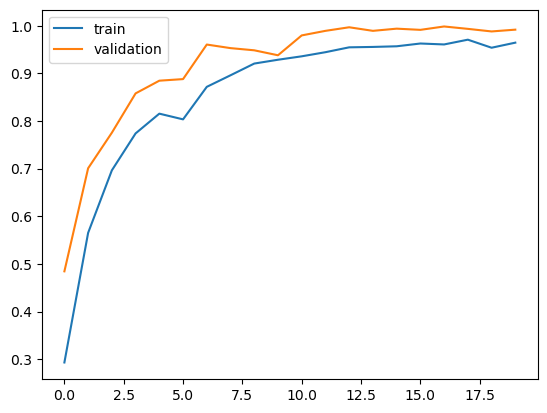

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 4-1-2. 유사도가 높고 분류기만 분석했을 때도 성능이 높기 떄문에 conv freeze후 훈련 진행

In [ ]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
# from tensorflow.keras.layers import BatchNormalization

# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications import ResNet50V2
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.applications import MobileNetV2

# def create_model(model_name='vgg16', verbose=False):
#     input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#     if model_name == 'vgg16':
#         model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
#     elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
#         model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
#     elif model_name == 'xception': # Inception을 기초로 한 모델
#         model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
#     elif model_name == 'mobilenet':
#         model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

#     x = model.output

#     # 분류기
#     x = GlobalAveragePooling2D()(x)
#     if model_name != 'vgg16':
#         x = Dropout(rate=0.5)(x)
#     x = Dense(50, activation='relu')(x)
#     if model_name != 'vgg16':
#         x = Dropout(rate=0.5)(x)
#     output = Dense(5, activation='softmax', name='output')(x)
    
#     model = Model(inputs=input_tensor, outputs=output)
    
#     if verbose:
#         model.summary()
    
#     return model

In [14]:
# from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Accuracy
# from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# IMAGE_SIZE = 64
# BATCH_SIZE = 64

# def fine_tune(datas, model_name, aug, preprocess):
#     FIRST_EPOCHS = 10
#     SECOND_EPOCHS = 20
    
#     train_file_paths, train_targets, \
#     validation_file_paths, validation_targets, \
#     test_file_paths, test_targets = datas

#     train_dataset = Dataset(train_file_paths, 
#                         train_targets, 
#                         batch_size=BATCH_SIZE, 
#                         aug=aug, 
#                         preprocess=preprocess, 
#                         shuffle=True)

#     validation_dataset = Dataset(validation_file_paths, 
#                             validation_targets, 
#                             batch_size=BATCH_SIZE, 
#                             preprocess=preprocess)
    
#     model = create_model(model_name=model_name, verbose=True)
#     model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


#     # 콜백 정의
#     mcp_cb = ModelCheckpoint(
#         filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
#         monitor='val_loss',
#         save_best_only=False,
#         save_weights_only=True,
#         mode='min'
#     )

#     rlr_cb = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         min_lr=1e-6,
#         mode='min',
#         verbose=1
#     )

#     ely_cb = EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         mode='min',
#         verbose=1
#     )

#     callbacks = [mcp_cb, rlr_cb, ely_cb]
    
#     # feature extractor layer들을 전부 freeze
#     for layer in model.layers[:-3]:
#         layer.trainable = False

#     model.fit(train_dataset, 
#               batch_size=BATCH_SIZE, 
#               epochs=FIRST_EPOCHS, 
#               validation_data=validation_dataset)

#     # 배치 정규화만 freeze 진행
#     # for layer in model.layers:
#     #     if not isinstance(layer, layers.BatchNormalization):
#     #         layer.trainable = True

#     # 부분 freeze 진행
#     # for layer in model.layers[:85]:
#     #     layer.trainable = False
    
#     model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
#     history = model.fit(train_dataset, 
#               batch_size=BATCH_SIZE, 
#               epochs=SECOND_EPOCHS, 
#               validation_data=validation_dataset,
#               callbacks = callbacks)
    
#     return model, history

In [ ]:
# # freeze 확인하기
# for i, layer in enumerate(model.layers):
#     layer.trainable = False
#     print(i + 1, '.', layer.name, 'trainable:', layer.trainable)

# print('\n######### classifier layers ######### ')
# for layer in model.layers[-3:]:
#     print(layer.name, 'trainable:', layer.trainable)

In [51]:
# from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
# import albumentations as A

# train_file_paths = train_df['file_paths'].values
# train_targets = train_df['targets'].values

# validation_file_paths = validation_df['file_paths'].values
# validation_targets = validation_df['targets'].values

# test_file_paths = test_df['file_paths'].values
# test_targets = test_df['targets'].values

# aug = A.Compose([
#     A.ShiftScaleRotate(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
# ])

# model, history = fine_tune((train_file_paths, train_targets,
#            validation_file_paths, validation_targets,
#            test_file_paths, test_targets),
#           'vgg16', 
#           aug,
#           vgg16_preprocess_input)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 112s 742ms/step - acc: 0.6109 - loss: 3.9094 - val_acc: 0.9638 - val_loss: 0.1209
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 126s 839ms/step - acc: 0.9179 - loss: 0.3082 - val_acc: 0.9975 - val_loss: 0.0219
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 884ms/step - acc: 0.9560 - loss: 0.1487 - val_acc: 0.9996 - val_loss: 0.0070
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 134s 895ms/step - acc: 0.9659 - loss: 0.1103 - val_acc: 1.0000 - val_loss: 0.0056
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 853ms/step - acc: 0.9749 - loss: 0.0845 - val_acc: 1.0000 - val_loss: 0.0033
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 829ms/step - acc: 0.9803 - loss: 0.0610 - val_acc: 1.0000 - val_loss: 0.0028
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 847ms/step - acc: 0.9841 - loss: 0.0479 - val_acc: 1.0000 - val_loss: 0.0023
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 874ms/step - acc: 0.9852 - loss: 0.0461 - val_acc: 1.0000 - val_loss: 0.0059
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━

## 4-2-1. 훈련데이터 보다 검증 데이터가 높게 나와 일반화를 통한 수치값의 변화가 있는지 확인 훈련.

In [15]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 99s 659ms/step - acc: 0.5775 - loss: 3.9141 - val_acc: 0.9621 - val_loss: 0.1148
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 40254s 270s/step - acc: 0.8387 - loss: 0.5718 - val_acc: 0.9958 - val_loss: 0.0323
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 812ms/step - acc: 0.8630 - loss: 0.4250 - val_acc: 1.0000 - val_loss: 0.0171
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 810ms/step - acc: 0.8805 - loss: 0.3724 - val_acc: 1.0000 - val_loss: 0.0173
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 831ms/step - acc: 0.8856 - loss: 0.3271 - val_acc: 1.0000 - val_loss: 0.0154
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 843ms/step - acc: 0.9064 - loss: 0.2721 - val_acc: 1.0000 - val_loss: 0.0110
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 849ms/step - acc: 0.9018 - loss: 0.2893 - val_acc: 1.0000 - val_loss: 0.0082
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 851ms/step - acc: 0.9079 - loss: 0.2639 - val_acc: 1.0000 - val_loss: 0.0073
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━

In [18]:
test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=vgg16_preprocess_input)

model.evaluate(test_dataset, batch_size=64)

47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 492ms/step - acc: 1.0000 - loss: 0.0021


[0.0021738868672400713, 1.0]

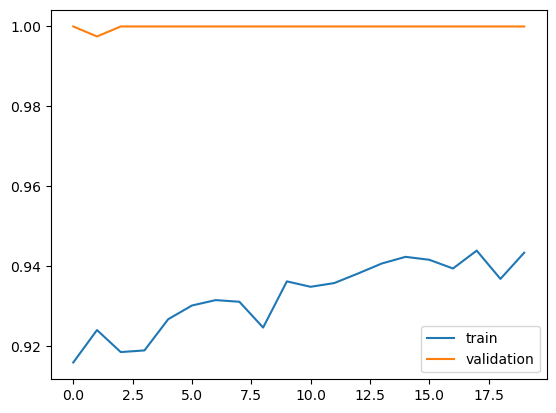

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 4-2-2. l2 규제를 통하여 검증데이터 성능과 훈련 데이터 성능을 유사하게 맞추려고 진행.

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5, kernel_regularizer=l2(1e-4))(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5, kernel_regularizer=l2(1e-4))(x)
    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [21]:
import gc

gc.collect()

7837

In [22]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 707ms/step - acc: 0.5814 - loss: 3.9854 - val_acc: 0.9779 - val_loss: 0.1103
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 831ms/step - acc: 0.8324 - loss: 0.6897 - val_acc: 0.9937 - val_loss: 0.0467
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 146s 972ms/step - acc: 0.8693 - loss: 0.4800 - val_acc: 0.9967 - val_loss: 0.0287
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 149s 990ms/step - acc: 0.8794 - loss: 0.3869 - val_acc: 1.0000 - val_loss: 0.0194
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 145s 965ms/step - acc: 0.8903 - loss: 0.3371 - val_acc: 1.0000 - val_loss: 0.0140
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 130s 865ms/step - acc: 0.8945 - loss: 0.3089 - val_acc: 1.0000 - val_loss: 0.0121
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - acc: 0.9060 - loss: 0.2784 - val_acc: 1.0000 - val_loss: 0.0126
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 148s 985ms/step - acc: 0.9088 - loss: 0.2722 - val_acc: 1.0000 - val_loss: 0.0089
Epoch 9/10
150/150 ━━━━━━━━

KeyboardInterrupt: 

## 4-2-3. 모델의 복잡성을 높이기 위해 layer unfreeze 진행

In [33]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 7개의 레이어 unfreeze
    for layer in model.layers[-7:]:
        layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [34]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - acc: 0.5901 - loss: 4.1173 - val_acc: 0.9796 - val_loss: 0.1272
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 925ms/step - acc: 0.8458 - loss: 0.5742 - val_acc: 0.9875 - val_loss: 0.0569
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - acc: 0.8652 - loss: 0.4353 - val_acc: 1.0000 - val_loss: 0.0202
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - acc: 0.8749 - loss: 0.3730 - val_acc: 1.0000 - val_loss: 0.0129
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 851ms/step - acc: 0.8946 - loss: 0.3105 - val_acc: 1.0000 - val_loss: 0.0108
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 872ms/step - acc: 0.8878 - loss: 0.3190 - val_acc: 0.9975 - val_loss: 0.0128
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 135s 899ms/step - acc: 0.9079 - loss: 0.2654 - val_acc: 1.0000 - val_loss: 0.0095
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 145s 965ms/step - acc: 0.9066 - loss: 0.2718 - val_acc: 1.0000 - val_loss: 0.0096
Epoch 9/10
122/150 ━━━━━━━━━━━━━━

KeyboardInterrupt: 

## 4-2-4. 데이터의 복잡성을 더 훈련 시키기 위하여 layer 층을 1층 더 높여 훈련 진행. 
- 규제 제거

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [37]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 7개의 레이어 unfreeze
    for layer in model.layers[-11:]:
        layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [38]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
# aug = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=40, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
#     A.CLAHE(p=0.5),
#     A.RandomShadow(p=0.5),
#     A.GaussianBlur(p=0.5),
#     A.HueSaturationValue(p=0.5),
#     A.GaussNoise(p=0.5),
#     A.RandomGamma(p=0.5),
# ], p=0.5)

aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 836ms/step - acc: 0.6400 - loss: 3.9761 - val_acc: 0.9729 - val_loss: 0.0955
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 145s 966ms/step - acc: 0.9057 - loss: 0.4188 - val_acc: 0.9946 - val_loss: 0.0240
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 130s 867ms/step - acc: 0.9319 - loss: 0.2718 - val_acc: 1.0000 - val_loss: 0.0130
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 136s 909ms/step - acc: 0.9392 - loss: 0.2197 - val_acc: 0.9954 - val_loss: 0.0122
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 147s 977ms/step - acc: 0.9521 - loss: 0.1622 - val_acc: 0.9975 - val_loss: 0.0084
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - acc: 0.9510 - loss: 0.1776 - val_acc: 1.0000 - val_loss: 0.0052
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - acc: 0.9600 - loss: 0.1290 - val_acc: 1.0000 - val_loss: 0.0032
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.9587 - loss: 0.1308 - val_acc: 1.0000 - val_loss: 0.0050
Epoch 9/10
150/150 ━━━━━━━━━━━━━━

## 4-2-5. layer 1층만 높였을 때 성능이 떨어진 부분을 확인.
- 훈련데이터보다 검증데이터 수치가 지속적으로 높기 때문에 모델의 규제 강도를 높여, 일반화 과정을 높이고 정확도 수치를 유사하게 만들기 위해 훈련

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5, kernel_regularizer=l2(1e-3))(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5, kernel_regularizer=l2(1e-3))(x)
    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [40]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 7개의 레이어 unfreeze
    # for layer in model.layers[-11:]:
    #     layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [41]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │        25,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,740,593 (56.23 MB)

 Trainable params: 14,740,593 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 715ms/step - acc: 0.5883 - loss: 4.2495 - val_acc: 0.9750 - val_loss: 0.1050
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 135s 902ms/step - acc: 0.8461 - loss: 0.6720 - val_acc: 0.9971 - val_loss: 0.0300
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 885ms/step - acc: 0.8619 - loss: 0.4789 - val_acc: 0.9942 - val_loss: 0.0224
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 927ms/step - acc: 0.8800 - loss: 0.3713 - val_acc: 1.0000 - val_loss: 0.0131
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 134s 890ms/step - acc: 0.8862 - loss: 0.3533 - val_acc: 1.0000 - val_loss: 0.0120
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 132s 880ms/step - acc: 0.8913 - loss: 0.3092 - val_acc: 1.0000 - val_loss: 0.0090
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 144s 957ms/step - acc: 0.9094 - loss: 0.2598 - val_acc: 1.0000 - val_loss: 0.0065
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 134s 891ms/step - acc: 0.9028 - loss: 0.2834 - val_acc: 1.0000 - val_loss: 0.0070
Epoch 9/10
150/150 ━━━━━

## 4-2-6. 규제 강도를 높여도 val_data가 매우 높은 부분 확인
- 분류기 뉴련 수 및 layer를 높인 후 드롭아웃 비율 추가

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l1, l2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [48]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 7개의 레이어 unfreeze
    # for layer in model.layers[-11:]:
    #     layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [49]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             

 Total params: 15,113,029 (57.65 MB)

 Trainable params: 15,111,493 (57.65 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 717ms/step - acc: 0.2354 - loss: 2.4814 - val_acc: 0.5525 - val_loss: 1.1904
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 812ms/step - acc: 0.3247 - loss: 1.7369 - val_acc: 0.5917 - val_loss: 1.1081
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 124s 825ms/step - acc: 0.3805 - loss: 1.5017 - val_acc: 0.6050 - val_loss: 1.0701
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 845ms/step - acc: 0.4162 - loss: 1.3827 - val_acc: 0.6371 - val_loss: 1.0442
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 849ms/step - acc: 0.4346 - loss: 1.3583 - val_acc: 0.6687 - val_loss: 1.0362
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 131s 869ms/step - acc: 0.4489 - loss: 1.3333 - val_acc: 0.7000 - val_loss: 1.0140
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 134s 890ms/step - acc: 0.4369 - loss: 1.3477 - val_acc: 0.6550 - val_loss: 1.0289
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 129s 861ms/step - acc: 0.4330 - loss: 1.3428 - val_acc: 0.6721 - val_loss: 1.0197
Epoch 9/10
150/150 ━━━━━

## 4-2-7. 훈련 데이터 성능이 낮게 나와서 데이터 증강 확률을 낮춰서 성능을 높이려고 진행.
- 규제 해제

In [54]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l1, l2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [55]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 16

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 7개의 레이어 unfreeze
    # for layer in model.layers[-11:]:
    #     layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [56]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
    # A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    # A.CLAHE(p=0.5),
    # A.RandomShadow(p=0.5),
    # A.GaussianBlur(p=0.5),
    # A.HueSaturationValue(p=0.5),
    # A.GaussNoise(p=0.5),
    # A.RandomGamma(p=0.5),
], p=0.2)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             

 Total params: 15,113,029 (57.65 MB)

 Trainable params: 15,111,493 (57.65 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 129s 214ms/step - acc: 0.2783 - loss: 2.2285 - val_acc: 0.5667 - val_loss: 1.0853
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 133s 222ms/step - acc: 0.4421 - loss: 1.3664 - val_acc: 0.6246 - val_loss: 1.0313
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 135s 225ms/step - acc: 0.4891 - loss: 1.2577 - val_acc: 0.6237 - val_loss: 1.0248
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 145s 242ms/step - acc: 0.5118 - loss: 1.2330 - val_acc: 0.6212 - val_loss: 1.0246
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 148s 246ms/step - acc: 0.4910 - loss: 1.2376 - val_acc: 0.6142 - val_loss: 1.0083
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 145s 242ms/step - acc: 0.4895 - loss: 1.2679 - val_acc: 0.5967 - val_loss: 1.0249
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 142s 237ms/step - acc: 0.4940 - loss: 1.2488 - val_acc: 0.5692 - val_loss: 1.0516
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 144s 241ms/step - acc: 0.4985 - loss: 1.2422 - val_acc: 0.6242 - val_loss: 1.0045
Epoch 9/10
600/600 ━━━━━

KeyboardInterrupt: 

In [57]:
gc.collect()

24957

## 4-2-8. 드롭아웃 비율을 조정하여 훈련데이터와 검증데이터의 성능을 유사하게 맞추려고 진행.

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l1, l2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.2)(x)

    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [61]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
    # A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    # A.CLAHE(p=0.5),
    # A.RandomShadow(p=0.5),
    # A.GaussianBlur(p=0.5),
    # A.HueSaturationValue(p=0.5),
    # A.GaussNoise(p=0.5),
    # A.RandomGamma(p=0.5),
], p=0.2)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             

 Total params: 15,113,029 (57.65 MB)

 Trainable params: 15,111,493 (57.65 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 123s 205ms/step - acc: 0.4311 - loss: 1.4942 - val_acc: 0.8221 - val_loss: 0.5443
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 148s 246ms/step - acc: 0.6854 - loss: 0.8492 - val_acc: 0.8483 - val_loss: 0.4608
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 162s 270ms/step - acc: 0.6969 - loss: 0.7876 - val_acc: 0.8671 - val_loss: 0.4273
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 148s 246ms/step - acc: 0.7202 - loss: 0.7343 - val_acc: 0.8700 - val_loss: 0.4059
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 151s 251ms/step - acc: 0.7178 - loss: 0.7364 - val_acc: 0.8796 - val_loss: 0.3990
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 150s 250ms/step - acc: 0.7188 - loss: 0.7341 - val_acc: 0.8679 - val_loss: 0.4022
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 144s 239ms/step - acc: 0.7190 - loss: 0.7282 - val_acc: 0.8746 - val_loss: 0.3900
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 135s 225ms/step - acc: 0.7190 - loss: 0.7608 - val_acc: 0.8683 - val_loss: 0.3986
Epoch 9/10
600/600 ━━━━━

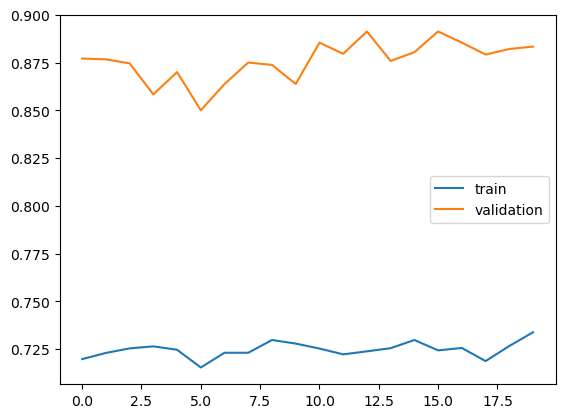

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 4-2-9. 규제를 해제하여 훈련데이터 성능을 높이려고 진행

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l1, l2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.2)(x)

    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [64]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# # 데이터 증강 설정
# aug = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=40, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
#     A.RandomBrightnessContrast(p=0.5)
#     # A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
#     # A.CLAHE(p=0.5),
#     # A.RandomShadow(p=0.5),
#     # A.GaussianBlur(p=0.5),
#     # A.HueSaturationValue(p=0.5),
#     # A.GaussNoise(p=0.5),
#     # A.RandomGamma(p=0.5),
# ], p=0.2)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          None,
          vgg16_preprocess_input)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             

 Total params: 15,113,029 (57.65 MB)

 Trainable params: 15,111,493 (57.65 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 110s 183ms/step - acc: 0.4826 - loss: 1.3727 - val_acc: 0.8242 - val_loss: 0.4844
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 122s 204ms/step - acc: 0.7271 - loss: 0.7272 - val_acc: 0.8792 - val_loss: 0.3736
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 129s 216ms/step - acc: 0.7497 - loss: 0.6553 - val_acc: 0.8779 - val_loss: 0.3633
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 129s 215ms/step - acc: 0.7643 - loss: 0.6266 - val_acc: 0.8879 - val_loss: 0.3339
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 130s 217ms/step - acc: 0.7667 - loss: 0.6153 - val_acc: 0.9075 - val_loss: 0.3215
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 131s 218ms/step - acc: 0.7533 - loss: 0.6358 - val_acc: 0.8958 - val_loss: 0.3174
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 132s 220ms/step - acc: 0.7681 - loss: 0.6205 - val_acc: 0.8954 - val_loss: 0.3179
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 132s 220ms/step - acc: 0.7575 - loss: 0.6434 - val_acc: 0.8863 - val_loss: 0.3215
Epoch 9/10
600/600 ━━━━━

KeyboardInterrupt: 

## 4-2-10. 훈련 데이터 성능을 높이기 위해 데이터 증강 해제 및 규제 해제

In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l1, l2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.2)(x)

    output = Dense(5, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [70]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 7개의 레이어 unfreeze
    # for layer in model.layers[-11:]:
    #     layer.trainable = True
    
    model.compile(optimizer=Adam(1e-4), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [71]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# # 데이터 증강 설정
# aug = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Rotate(limit=40, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
#     A.RandomBrightnessContrast(p=0.5)
#     # A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
#     # A.CLAHE(p=0.5),
#     # A.RandomShadow(p=0.5),
#     # A.GaussianBlur(p=0.5),
#     # A.HueSaturationValue(p=0.5),
#     # A.GaussNoise(p=0.5),
#     # A.RandomGamma(p=0.5),
# ], p=0.2)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          None,
          vgg16_preprocess_input)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             

 Total params: 15,113,029 (57.65 MB)

 Trainable params: 15,111,493 (57.65 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 117s 387ms/step - acc: 0.4312 - loss: 1.5848 - val_acc: 0.7975 - val_loss: 0.5736
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 422ms/step - acc: 0.7168 - loss: 0.7497 - val_acc: 0.8400 - val_loss: 0.4574
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 124s 414ms/step - acc: 0.7598 - loss: 0.6437 - val_acc: 0.8575 - val_loss: 0.4047
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 125s 417ms/step - acc: 0.7644 - loss: 0.6256 - val_acc: 0.8779 - val_loss: 0.3747
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 125s 418ms/step - acc: 0.7703 - loss: 0.5996 - val_acc: 0.8767 - val_loss: 0.3615
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 424ms/step - acc: 0.7681 - loss: 0.6032 - val_acc: 0.8712 - val_loss: 0.3590
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 126s 418ms/step - acc: 0.7707 - loss: 0.6143 - val_acc: 0.8875 - val_loss: 0.3390
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 126s 420ms/step - acc: 0.7850 - loss: 0.5867 - val_acc: 0.8821 - val_loss: 0.3374
Epoch 9/10
300/300 ━━━━━

In [72]:
gc.collect()

10056

## 4-2-11. 데이터 증강 및 분류기 모델 DNN 층 갯수 변경 및 드롭아웃 추가

In [74]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 512)            │             

 Total params: 15,113,029 (57.65 MB)

 Trainable params: 15,111,493 (57.65 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 115s 383ms/step - acc: 0.3495 - loss: 1.7708 - val_acc: 0.7829 - val_loss: 0.6538
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 126s 420ms/step - acc: 0.5871 - loss: 1.0474 - val_acc: 0.8325 - val_loss: 0.5282
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 126s 421ms/step - acc: 0.6426 - loss: 0.9448 - val_acc: 0.8454 - val_loss: 0.4882
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 126s 421ms/step - acc: 0.6467 - loss: 0.9180 - val_acc: 0.8517 - val_loss: 0.4719
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 423ms/step - acc: 0.6491 - loss: 0.8984 - val_acc: 0.8583 - val_loss: 0.4644
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 423ms/step - acc: 0.6634 - loss: 0.8792 - val_acc: 0.8592 - val_loss: 0.4583
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 128s 426ms/step - acc: 0.6525 - loss: 0.9128 - val_acc: 0.8554 - val_loss: 0.4586
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 451ms/step - acc: 0.6669 - loss: 0.8845 - val_acc: 0.8700 - val_loss: 0.4462
Epoch 9/10
300/300 ━━━━━

KeyboardInterrupt: 

In [75]:
def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = base_model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    output = Dense(5, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()

    return model


In [76]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-3]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 7개의 레이어 unfreeze
    # for layer in model.layers[-11:]:
    #     layer.trainable = True
    
    model.compile(optimizer=Adam(1e-4), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [77]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 1024)           │             

 Total params: 15,904,581 (60.67 MB)

 Trainable params: 15,900,997 (60.66 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 114s 376ms/step - acc: 0.2158 - loss: 2.3687 - val_acc: 0.4779 - val_loss: 1.4636
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 125s 417ms/step - acc: 0.2989 - loss: 1.6990 - val_acc: 0.3650 - val_loss: 1.4290
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 127s 422ms/step - acc: 0.3165 - loss: 1.5596 - val_acc: 0.3571 - val_loss: 1.4456
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 129s 429ms/step - acc: 0.3413 - loss: 1.5068 - val_acc: 0.4475 - val_loss: 1.3912
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 129s 429ms/step - acc: 0.3603 - loss: 1.4825 - val_acc: 0.4238 - val_loss: 1.3835
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 130s 434ms/step - acc: 0.3395 - loss: 1.5045 - val_acc: 0.5217 - val_loss: 1.3851
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 130s 432ms/step - acc: 0.3490 - loss: 1.5015 - val_acc: 0.3671 - val_loss: 1.4098
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 130s 434ms/step - acc: 0.3347 - loss: 1.5040 - val_acc: 0.5267 - val_loss: 1.3955
Epoch 9/10
300/300 ━━━━━

KeyboardInterrupt: 

## 4-2-12. 분류기 ANN 구조 변경 후 단순화

In [78]:
def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = base_model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    x = Dense(100, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    x = Dense(30, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    output = Dense(5, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()

    return model


In [79]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'vgg16', 
          aug,
          vgg16_preprocess_input)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 100)            │             

 Total params: 14,769,693 (56.34 MB)

 Trainable params: 14,769,433 (56.34 MB)

 Non-trainable params: 260 (1.02 KB)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 114s 379ms/step - acc: 0.1825 - loss: 2.4612 - val_acc: 0.2200 - val_loss: 1.6523
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 126s 419ms/step - acc: 0.2115 - loss: 1.8003 - val_acc: 0.2858 - val_loss: 1.5491
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 450ms/step - acc: 0.2503 - loss: 1.6286 - val_acc: 0.3850 - val_loss: 1.5136
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 450ms/step - acc: 0.2761 - loss: 1.5848 - val_acc: 0.4308 - val_loss: 1.4960
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 134s 446ms/step - acc: 0.2787 - loss: 1.5704 - val_acc: 0.4400 - val_loss: 1.4908
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 450ms/step - acc: 0.2857 - loss: 1.5573 - val_acc: 0.4650 - val_loss: 1.4852
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 450ms/step - acc: 0.3076 - loss: 1.5531 - val_acc: 0.4942 - val_loss: 1.4843
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 449ms/step - acc: 0.2751 - loss: 1.5652 - val_acc: 0.4512 - val_loss: 1.4870
Epoch 9/10
300/300 ━━━━━

KeyboardInterrupt: 

## 4-3. vgg 모델에서 xception 모델로 변경.
- fine_tuning을 위한 layer를 유동적으로 조절하기 위한 모델 변경

In [92]:
def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = base_model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    x = Dense(100, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    x = Dense(30, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)  # Dropout 비율을 높임

    output = Dense(5, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()

    return model


In [96]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-9]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 9개의 레이어 unfreeze (-19)
    for layer in model.layers[-9:]:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-4), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [97]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer_19[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add_12[0][0]    

 Total params: 21,070,085 (80.38 MB)

 Trainable params: 21,015,297 (80.17 MB)

 Non-trainable params: 54,788 (214.02 KB)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - acc: 0.3861 - loss: 1.6945 - val_acc: 0.8629 - val_loss: 0.5149
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - acc: 0.6308 - loss: 0.9883 - val_acc: 0.9054 - val_loss: 0.3794
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 143ms/step - acc: 0.6902 - loss: 0.8452 - val_acc: 0.9333 - val_loss: 0.2823
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 144ms/step - acc: 0.7213 - loss: 0.7736 - val_acc: 0.9529 - val_loss: 0.2099
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - acc: 0.7503 - loss: 0.7053 - val_acc: 0.9667 - val_loss: 0.1738
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - acc: 0.7740 - loss: 0.6681 - val_acc: 0.9675 - val_loss: 0.1567
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 150ms/step - acc: 0.7740 - loss: 0.6758 - val_acc: 0.9754 - val_loss: 0.1440
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 151ms/step - acc: 0.7801 - loss: 0.6291 - val_acc: 0.9775 - val_loss: 0.1343
Epoch 9/10
300/300 ━━━━━━━━━━━━━

KeyboardInterrupt: 

## 4-3-1. layer 층을 높여 복잡도를 높이려고 layer를 1계층 높여 unfreeze 진행

In [98]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-9]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 9개의 레이어 unfreeze (-19)
    for layer in model.layers[-19:]:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-4), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [100]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer_21[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add_36[0][0]    

 Total params: 21,070,085 (80.38 MB)

 Trainable params: 21,015,297 (80.17 MB)

 Non-trainable params: 54,788 (214.02 KB)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - acc: 0.4033 - loss: 1.6553 - val_acc: 0.8775 - val_loss: 0.5266
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - acc: 0.6399 - loss: 0.9610 - val_acc: 0.9154 - val_loss: 0.3700
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - acc: 0.6844 - loss: 0.8658 - val_acc: 0.9371 - val_loss: 0.2707
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - acc: 0.7203 - loss: 0.7875 - val_acc: 0.9500 - val_loss: 0.2271
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - acc: 0.7383 - loss: 0.7446 - val_acc: 0.9608 - val_loss: 0.1853
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 161ms/step - acc: 0.7485 - loss: 0.7293 - val_acc: 0.9617 - val_loss: 0.1838
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - acc: 0.7604 - loss: 0.6711 - val_acc: 0.9608 - val_loss: 0.1548
Epoch 8/10
 18/300 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - acc: 0.7401 - loss: 0.7481

KeyboardInterrupt: 

## 4-3-2. 층을 더욱 높여 추가 훈련 진행
- 복잡도가 너무 낮은 것으로 예상

In [103]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-9]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 9개의 레이어 unfreeze (-19)
    for layer in model.layers[-95:]:
        layer.trainable = True
    
    model.compile(optimizer=Adam(1e-4), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [104]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer_23[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add_60[0][0]    

 Total params: 21,070,085 (80.38 MB)

 Trainable params: 21,015,297 (80.17 MB)

 Non-trainable params: 54,788 (214.02 KB)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - acc: 0.3857 - loss: 1.8155 - val_acc: 0.8512 - val_loss: 0.5286
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - acc: 0.6223 - loss: 1.0133 - val_acc: 0.9079 - val_loss: 0.3505
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - acc: 0.6993 - loss: 0.8224 - val_acc: 0.9325 - val_loss: 0.2809
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - acc: 0.7255 - loss: 0.7678 - val_acc: 0.9546 - val_loss: 0.2180
Epoch 5/10
271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - acc: 0.7464 - loss: 0.7165

KeyboardInterrupt: 

## 4-3-3. 훈련 데이터 성능을 높이기 위하여 층을 더 높여 layer 훈련

In [105]:
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

IMAGE_SIZE = 64
BATCH_SIZE = 32

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 20
    
    train_file_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=preprocess, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=preprocess)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])


    # 콜백 정의
    mcp_cb = ModelCheckpoint(
        filepath="./callback_files/project03/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
        monitor='val_loss',
        save_best_only=False,
        save_weights_only=True,
        mode='min'
    )

    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )

    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    callbacks = [mcp_cb, rlr_cb, ely_cb]
    
    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-9]:
        layer.trainable = False

    model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=FIRST_EPOCHS, 
              validation_data=validation_dataset)

    # 마지막 9개의 레이어 unfreeze (-19)
    for layer in model.layers[:13]:
        layer.trainable = True
    
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, 
              batch_size=BATCH_SIZE, 
              epochs=SECOND_EPOCHS, 
              validation_data=validation_dataset,
              callbacks = callbacks)
    
    return model, history

In [106]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
import albumentations as A

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

# 데이터 증강 설정
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.8, 1.0), p=0.5),
    A.CLAHE(p=0.5),
    A.RandomShadow(p=0.5),
    A.GaussianBlur(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomGamma(p=0.5),
], p=0.5)


model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'xception', 
          aug,
          xception_preprocess_input)

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer_24[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        512 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_72 (Add)        │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add_72[0][0]    

 Total params: 21,070,085 (80.38 MB)

 Trainable params: 21,015,297 (80.17 MB)

 Non-trainable params: 54,788 (214.02 KB)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step - acc: 0.4190 - loss: 1.5614 - val_acc: 0.8650 - val_loss: 0.5041
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - acc: 0.6220 - loss: 0.9858 - val_acc: 0.9212 - val_loss: 0.3367
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - acc: 0.6920 - loss: 0.8516 - val_acc: 0.9421 - val_loss: 0.2598
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - acc: 0.7339 - loss: 0.7334 - val_acc: 0.9554 - val_loss: 0.2090
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 154ms/step - acc: 0.7492 - loss: 0.7232 - val_acc: 0.9679 - val_loss: 0.1749
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - acc: 0.7572 - loss: 0.7038 - val_acc: 0.9779 - val_loss: 0.1449
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - acc: 0.7771 - loss: 0.6481 - val_acc: 0.9737 - val_loss: 0.1474
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - acc: 0.7799 - loss: 0.6471 - val_acc: 0.9771 - val_loss: 0.1262
Epoch 9/10
300/300 ━━━━━━━━━━━━━

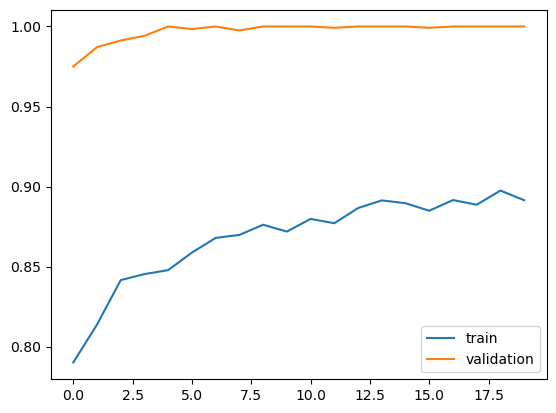

In [112]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()

## 5. 데이터 검증

In [113]:
test_dataset = Dataset(test_file_paths, 
                            test_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=xception_preprocess_input)

model.evaluate(test_dataset, batch_size=32)

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - acc: 1.0000 - loss: 0.0083


[0.008382637053728104, 1.0]

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step


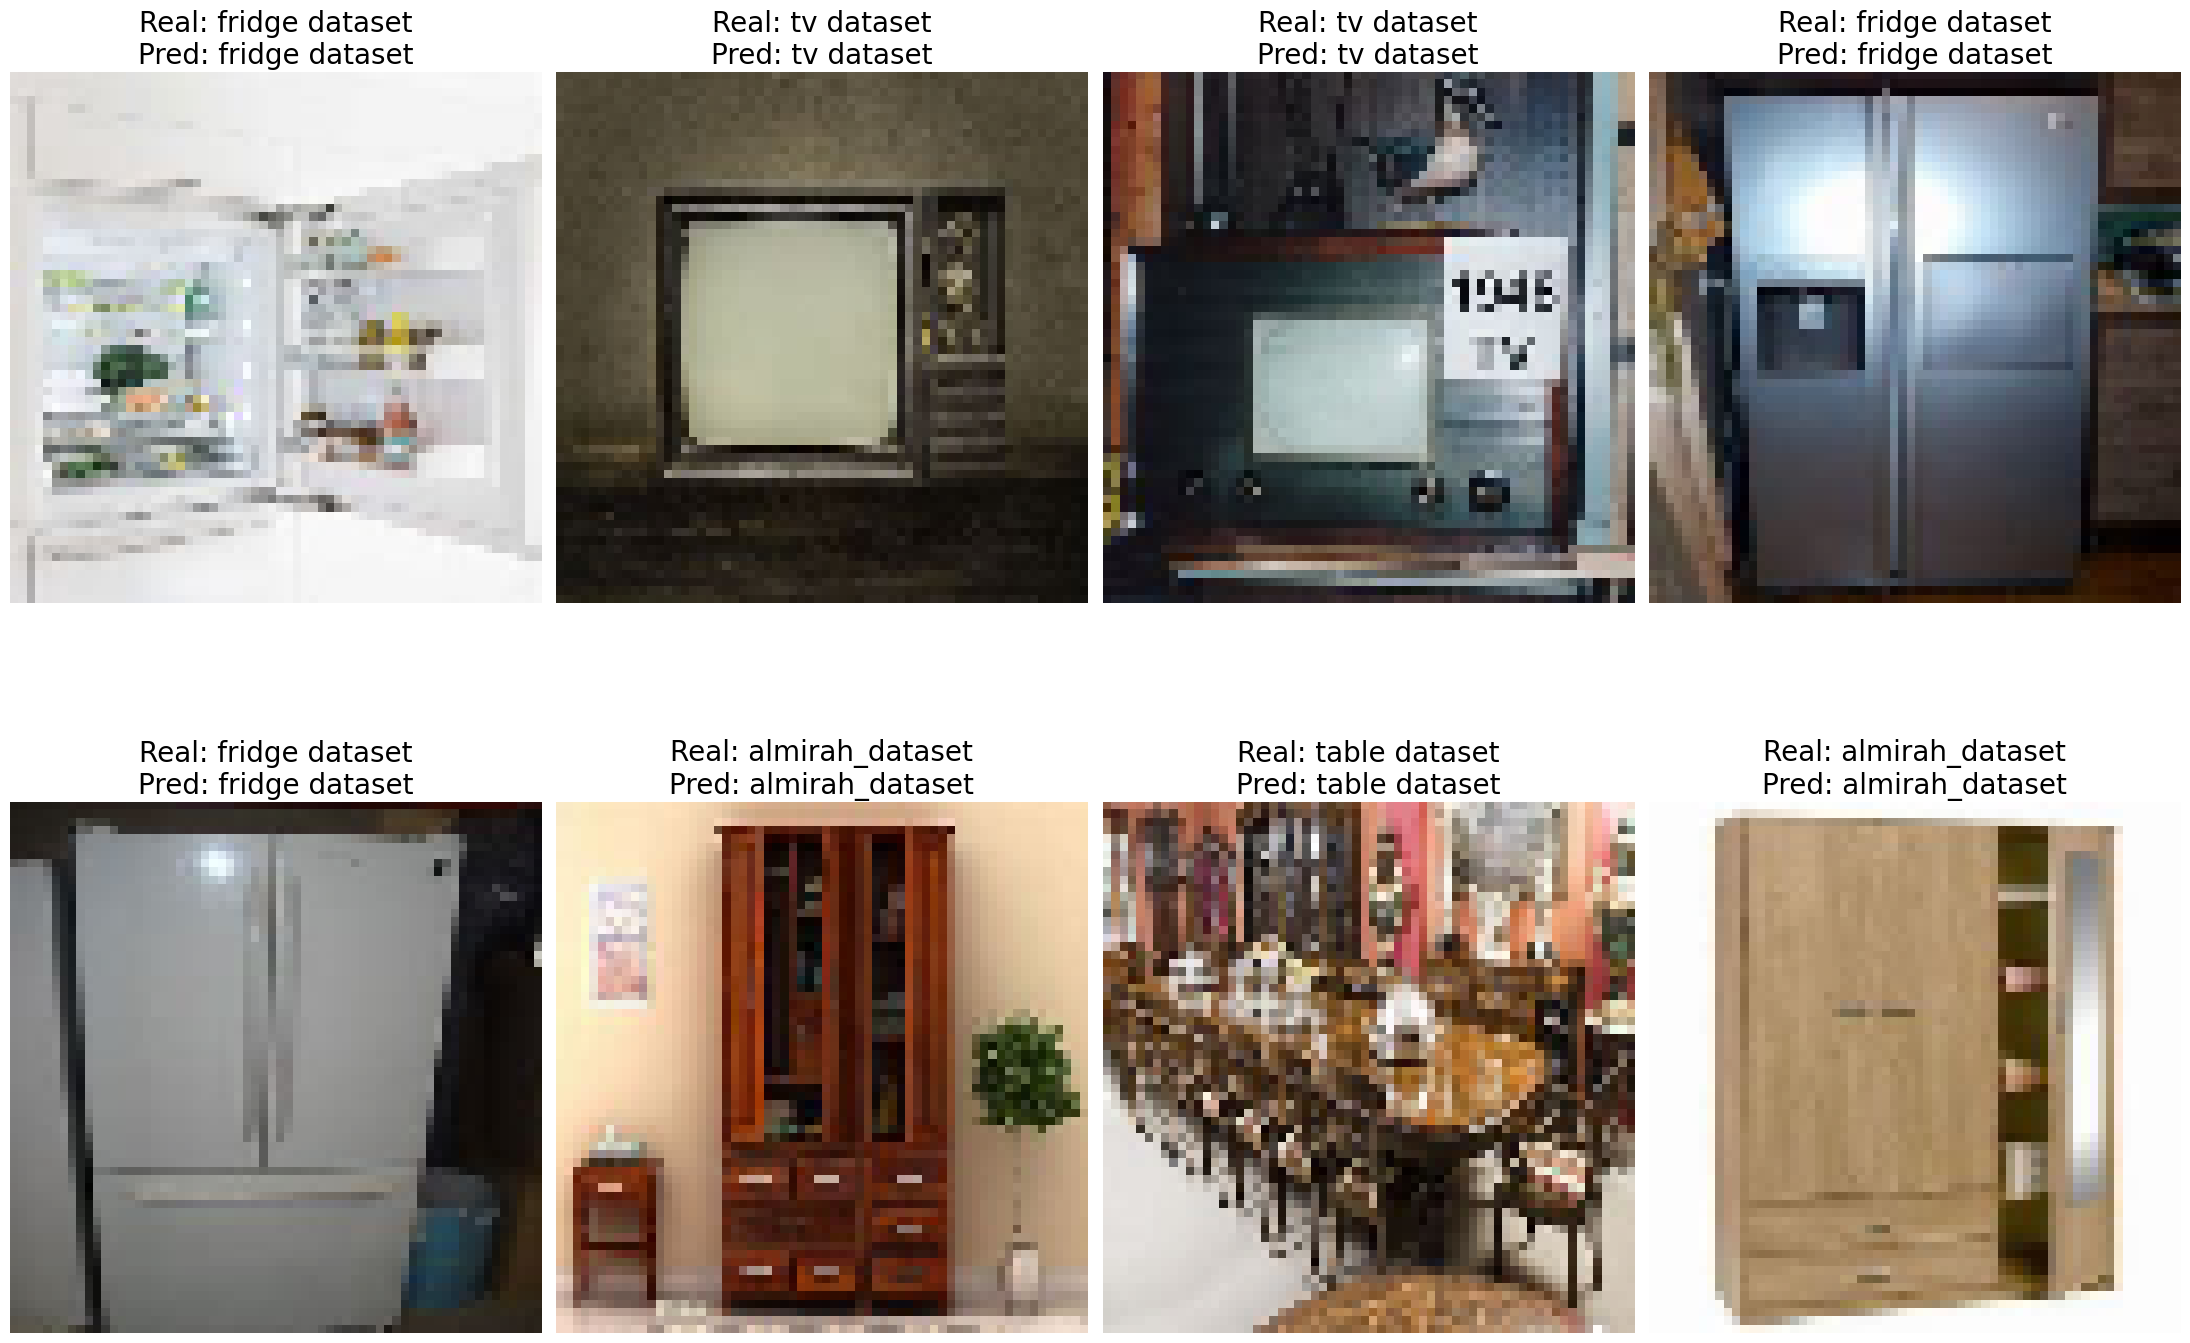

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 클래스 이름 정의
CLASS_NAMES = [
        'almirah_dataset', #0
        'chair_dataset', #1
        'fridge dataset', #2
        'table dataset', #3
        'tv dataset' #4
]

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
        # 오류 발생 시 빈 이미지 또는 대체 이미지 반환
        image = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
    return image

# 이미지 크기 설정
IMAGE_SIZE = 64
BATCH_SIZE = 64

# 이미지 시각화 함수 정의
def show_images(images, targets, predictions, nrows=2, ncols=4, fontsize=16):
    fig, axes = plt.subplots(figsize=(22, 16), nrows=nrows, ncols=ncols)
    axes = axes.flatten()  # axes를 1차원 배열로 변환

    for i in range(len(images)):
        ax = axes[i]
        img = images[i]
        ax.imshow(img)
        target = int(targets[i])
        prediction = int(predictions[i])
        ax.set_title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
        ax.axis('off')  # 축 숨기기

    # 사용되지 않는 subplot 숨기기
    for j in range(len(images), nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 테스트 데이터 제너레이터 생성
test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

test_dataset = Dataset(test_file_paths, 
                        test_targets, 
                        batch_size=BATCH_SIZE,
                        preprocess=xception_preprocess_input)

# 모델 예측 수행
pred_probas = model.predict(test_dataset)
pred_classes = np.argmax(pred_probas, axis=1)

# 원본 이미지 로드
real_test_images = np.array([load_and_preprocess_image(fp) for fp in test_file_paths])

# 테스트 데이터와 예측값 시각화 (제너레이터에서 이미지와 타겟을 가져옴)
show_images(real_test_images[:8], test_targets[:8], pred_classes[:8], fontsize=20)


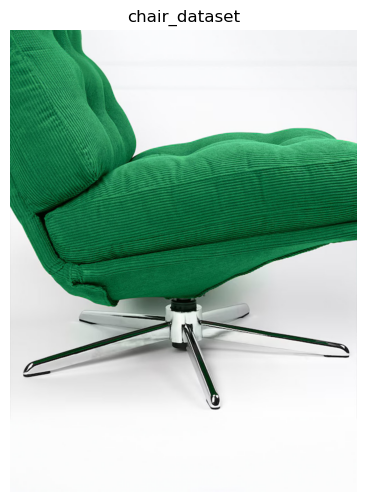

In [117]:
import matplotlib.pyplot as plt
import cv2

root_real_image_project03 = './images/real_project03.webp'

real_image_project03 = cv2.cvtColor(cv2.imread(root_real_image_project03), cv2.COLOR_BGR2RGB)

figure, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)

ax.imshow(real_image_project03)
ax.set_title('chair_dataset')
ax.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


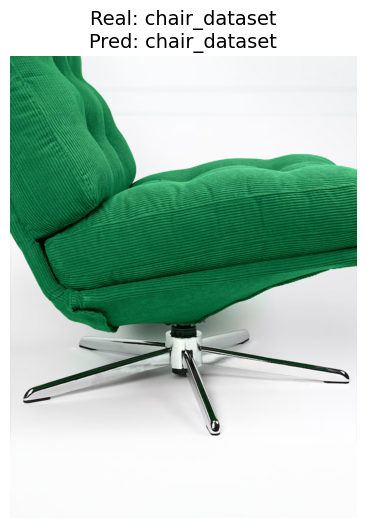

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

# 클래스 이름 정의
CLASS_NAMES = [
    'almirah_dataset', #0
    'chair_dataset', #1
    'fridge dataset', #2
    'table dataset', #3
    'tv dataset' #4
]

# 이미지 크기 설정
IMAGE_SIZE = 64

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(file_path, preprocess=None):
    image = cv2.imread(file_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        if preprocess:
            image = preprocess(image)
    else:
        print(f"Error loading image: {file_path}")
    return image

# 이미지 시각화 함수 정의
def show_single_image(image, target, prediction, fontsize=16):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Real: {CLASS_NAMES[target]}\nPred: {CLASS_NAMES[prediction]}', fontsize=fontsize)
    plt.axis('off')
    plt.show()

# 실제 이미지 경로
root_real_image_project02 = './images/real_project03.webp'
real_image_project02 = load_and_preprocess_image(root_real_image_project02, preprocess=xception_preprocess_input)
origin_image_project02 = cv2.cvtColor(cv2.imread(root_real_image_project02), cv2.COLOR_BGR2RGB)

# 모델 예측 수행
real_image_project02_expanded = np.expand_dims(real_image_project02, axis=0)  # 배치 차원을 추가
pred_probas = model.predict(real_image_project02_expanded)
pred_class = np.argmax(pred_probas, axis=1)[0]

# 실제 이미지 시각화
show_single_image(origin_image_project02, target=1, prediction=pred_class, fontsize=14)


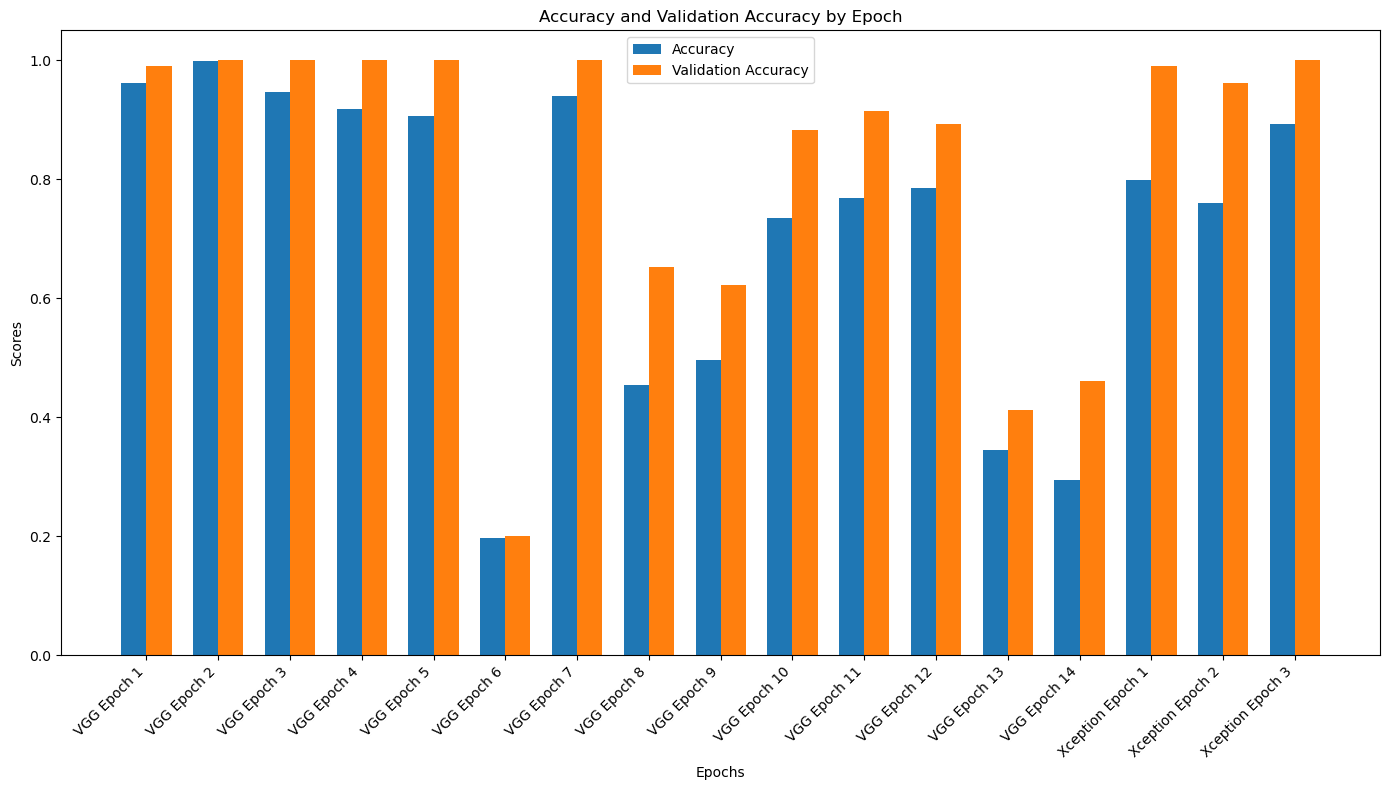

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation
labels = [
    'VGG Epoch 1', 'VGG Epoch 2', 'VGG Epoch 3',
    'VGG Epoch 4', 'VGG Epoch 5', 'VGG Epoch 6',
    'VGG Epoch 7', 'VGG Epoch 8', 'VGG Epoch 9',
    'VGG Epoch 10', 'VGG Epoch 11', 'VGG Epoch 12',
    'VGG Epoch 13', 'VGG Epoch 14',
    'Xception Epoch 1', 'Xception Epoch 2', 'Xception Epoch 3'
]

acc = [
    0.9612, 0.9979, 0.9464,
    0.9180, 0.9066, 0.1968,
    0.9401, 0.4534, 0.4952,
    0.7351, 0.7689, 0.7849,
    0.3439, 0.2943,
    0.7988, 0.7604, 0.8925
]

val_acc = [
    0.9908, 1.0000, 1.0000,
    1.0000, 1.0000, 0.2000,
    1.0000, 0.6521, 0.6212,
    0.8833, 0.9146, 0.8921,
    0.4121, 0.4604,
    0.9900, 0.9608, 1.0000
]

# Plotting the graph
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy')
rects2 = ax.bar(x + width/2, val_acc, width, label='Validation Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Epochs')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and Validation Accuracy by Epoch')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

fig.tight_layout()

plt.show()


## 6. 결론
- 모델 선택: VGG16 모델과 Xception 모델을 사용하였으며, 사전 훈련 모델에서는 유사도가 높은 부분을 확인하였습니다.
- 모델 성능 개선: 초기 훈련부터 분류기 부분만 훈련을 시켰을 때도 높은 성능을 보여줬습니다.
- 과소적합 방지: 복잡성을 높인 모델에서보다 fine_tuning을 진행하였을 때 층이 낮은 훈련 모델에서 높은 성능을 보여줬습니다.  
  이때, 훈련데이터보다 검증데이터가 매우 높은 수치로 나타나 훈련 데이터가 학습패턴을 학습 시키기 어려웠다고 판단하여 해당 증상을 해결하기 위해 fine_tuning layer freeze, 데이터증강, 훈련 모델 변경, 학습률 변경 분류기 모델을 수정하였으나 지속적으로 검증 데이터 및 테스트 데이터에서 높은 성능을 보여줬습니다.  
  이와 같은 결론으로 해당 데이터 셋이 분류가 매우 단순한 데이터셋이라는 부분으로 볼 수 있으며 실제 다른 이미지를 분석하더라도 정확하게 맞추는 성능을 확인하였습니다.

## 7. 느낀점
- 검증 데이터의 확률이 무조건 높다고 하여 무조건적인 과소적합이 아닐 수 있다는 생각을 하였으며 과소적합을 해소하기 위해 훈련이 쉬운 데이터에 대하여 일반화를 진행하다 보면
  오히려 성능을 떨어뜨릴 수 도 있다는 판단이 들었습니다.
- 또한 해당 모델의 경우 매우 높은 유사도를 보이고 있어 훈련데이터를 훈련을 많이 시키지 않더라도 검증 데이터가 높을 수 있다고 판단하였습니다.
- 위의 모델에서는 훈련데이터의 성능이 낮은 부분의 경우 모델의 일반화 작업 때문에 성능이 낮으며 훈련횟수를 증가시키면 수치를 더 높을 수 있음을 알았습니다.
- 차후 여러 모델을 훈련할 때는 모델의 복잡성을 높이기 위에 다양한 이미지 확보와 데이터 증강을 적절히 조절하여 훈련 데이터의 다양성을 확보하는 방향으로 진행되어야 할 것 같습니다.